# MRC dataset EDA
- specific 하려고 했으나 논리가 부실한 부분도 있을 것 같은데, 많은 피드백 부탁합니다
- 우선 klue/bert-base 기반으로 tokenize했으나, 최종 제출한 모델인 klue/roberta-large와 vocabulary를 공유하므로 별도의 추가 분석은 진행하지 않았습니다

In [1]:
from datasets import DatasetDict, load_from_disk
import pandas as pd
from transformers import AutoTokenizer
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

### 모델을 바꾸려면 여기서 바꿔주세요

In [2]:
MODEL1 = 'klue/bert-base'
MODEL2 = 'klue/roberta-large'
bert_tokenizer = AutoTokenizer.from_pretrained(MODEL1)
roberta_tokenizer = AutoTokenizer.from_pretrained(MODEL2)

In [3]:
train_data = load_from_disk('train_dataset')['train']
print(type(train_data))
train_data

<class 'datasets.arrow_dataset.Dataset'>


Dataset({
    features: ['title', 'context', 'question', 'id', 'answers', 'document_id', '__index_level_0__'],
    num_rows: 3952
})

불러온 DatasetDict를 pandas DataFrame으로 바꿔줍니다.  
위에서 볼 수 있듯 features 중 ['answers'] 는 ['answer_start'], ['text'] 로 나눠져서 따로 처리해야 하므로 나머지 feature만 일단 df로 바꿔줬습니다

In [4]:
df = pd.DataFrame()
title, context, question, id, answers, document_id = train_data['title'],train_data['context'],train_data['question'], train_data['id'],train_data['answers'],train_data['document_id']
df.insert(0,'title',title)
df.insert(1,'context',context)
df.insert(2, 'question', question)
df.insert(3, 'id', id)
# df.insert(4, 'answer_start', answers['answer_start'][0])
# df.insert(5, 'answer_text', answers['text'][0])
df.insert(4, 'document_id', document_id)

df

,title,context,question,id,document_id
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,5028
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,34146
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,47334
...,...,...,...,...,...
3947,이오 (위성),이오의 산\n이오의 산 목록\n 이오에는 100~150개의 산이 있다. 이들 산의 ...,대부분의 이오의 산이 형성되는데 영향을 끼친 것은?,mrc-0-005285,8275
3948,내니 다이어리,애니의 고군분투 뉴욕 입성기!!\n\n인류학자가 꿈인 21살 소녀 '애니(스칼렛 요...,애니는 어디서 태어났는가?,mrc-1-000699,37764
3949,빈 필하모니 관현악단,1842년에 작곡가이자 지휘자인 오토 니콜라이가 빈 궁정 오페라극장 소속 관현악단을...,1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?,mrc-0-003429,12730
3950,드래곤,원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...,드래곤의 암수 구분이 있는 신화는?,mrc-0-003956,10924


features 중 `['answers']` 는 `['answer_start']`, `['text']` 로 nested되어 있어서 따로 불러낸 후 병합하는 방식을 취했습니다 
또한 dataset 구조 상 바로 불러오면 '[answer]' 형태의 string이 dataframe에 저장되기 때문에 이를 정제하는 과정을 거쳤습니다

In [5]:
ans = train_data['answers']
ans_df = pd.DataFrame(ans)
ans_df

,answer_start,text
0,[235],[하원]
1,[212],[《경영의 실제》]
2,[510],[백성]
3,[625],[중국]
4,[30],[4개]
...,...,...
3947,[317],[지질 구조]
3948,[616],[뉴저지]
3949,[255],[칼 에케르트]
3950,[476],[슬라브 신화]


In [6]:
def cut_punct(inp):
    print(inp)
    return inp[1:-1]
ans_df['text'] = ans_df['text'].apply(lambda x: x[0])
ans_df['answer_start'] = ans_df['answer_start'].apply(lambda x: x[0])
ans_df

,answer_start,text
0,235,하원
1,212,《경영의 실제》
2,510,백성
3,625,중국
4,30,4개
...,...,...
3947,317,지질 구조
3948,616,뉴저지
3949,255,칼 에케르트
3950,476,슬라브 신화


dataframe을 병합해 완성했습니다.

In [7]:
df = pd.concat([df,ans_df], axis = 1)
df

,title,context,question,id,document_id,answer_start,text
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293,235,하원
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638,212,《경영의 실제》
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,5028,510,백성
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,34146,625,중국
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,47334,30,4개
...,...,...,...,...,...,...,...
3947,이오 (위성),이오의 산\n이오의 산 목록\n 이오에는 100~150개의 산이 있다. 이들 산의 ...,대부분의 이오의 산이 형성되는데 영향을 끼친 것은?,mrc-0-005285,8275,317,지질 구조
3948,내니 다이어리,애니의 고군분투 뉴욕 입성기!!\n\n인류학자가 꿈인 21살 소녀 '애니(스칼렛 요...,애니는 어디서 태어났는가?,mrc-1-000699,37764,616,뉴저지
3949,빈 필하모니 관현악단,1842년에 작곡가이자 지휘자인 오토 니콜라이가 빈 궁정 오페라극장 소속 관현악단을...,1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?,mrc-0-003429,12730,255,칼 에케르트
3950,드래곤,원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...,드래곤의 암수 구분이 있는 신화는?,mrc-0-003956,10924,476,슬라브 신화


context에서 preprocessing이 덜 되어 enter부분은 `\\n\\n` 으로 표기되어 있는, 대표적 [UNK] 유발자 몇개만 제거하는 함수입니다.  
최대한 원문을 유지하기 위해 해당 방법을 취했습니다.  
또한 다른 노트북(analysis_dataset_unks.ipynb)에서 [UNK] 토큰에 대한 분석을 보다 자세히 확인할 수 있습니다 

In [16]:
#최대한 원문을 유지하기 위해서 preprocessing을 최소화했음.
def clean(text, mapping_line):
    for p in mapping_line:
        text = text.replace(p, ' ')
    
    return text

mapping_line = ['\\n', '\n']

df['context'] = df['context'].apply(lambda x:clean(x,mapping_line))
df

,title,context,question,id,document_id,answer_start,text
0,미국 상원,미국 상의원 또는 미국 상원(United States Senate)은 양원제인 미국...,대통령을 포함한 미국의 행정부 견제권을 갖는 국가 기관은?,mrc-1-000067,18293,235,하원
1,인사조직관리,'근대적 경영학' 또는 '고전적 경영학'에서 현대적 경영학으로 전환되는 시기는 19...,현대적 인사조직관리의 시발점이 된 책은?,mrc-0-004397,51638,212,《경영의 실제》
2,강희제,강희제는 강화된 황권으로 거의 황제 중심의 독단적으로 나라를 이끌어 갔기에 자칫 전...,강희제가 1717년에 쓴 글은 누구를 위해 쓰여졌는가?,mrc-1-000362,5028,510,백성
3,금동삼존불감,"불상을 모시기 위해 나무나 돌, 쇠 등을 깎아 일반적인 건축물보다 작은 규모로 만든...",11~12세기에 제작된 본존불은 보통 어떤 나라의 특징이 전파되었나요?,mrc-0-001510,34146,625,중국
4,계사명 사리구,동아대학교박물관에서 소장하고 있는 계사명 사리구는 총 4개의 용기로 구성된 조선후기...,명문이 적힌 유물을 구성하는 그릇의 총 개수는?,mrc-0-000823,47334,30,4개
...,...,...,...,...,...,...,...
3947,이오 (위성),이오의 산 이오의 산 목록 이오에는 100~150개의 산이 있다. 이들 산의 평균...,대부분의 이오의 산이 형성되는데 영향을 끼친 것은?,mrc-0-005285,8275,317,지질 구조
3948,내니 다이어리,애니의 고군분투 뉴욕 입성기!! 인류학자가 꿈인 21살 소녀 '애니(스칼렛 요한슨...,애니는 어디서 태어났는가?,mrc-1-000699,37764,616,뉴저지
3949,빈 필하모니 관현악단,1842년에 작곡가이자 지휘자인 오토 니콜라이가 빈 궁정 오페라극장 소속 관현악단을...,1854년에 니콜라이의 뒤를 이어 상임 지휘자로서 활동한 인물은?,mrc-0-003429,12730,255,칼 에케르트
3950,드래곤,원어는 고대 그리스어까지 거슬러 올라간다. 영어 문헌에 이 말이 나타나기 시작한 것...,드래곤의 암수 구분이 있는 신화는?,mrc-0-003956,10924,476,슬라브 신화


예시 context 하나 찍어봤습니다. 
의도한 대로 나온 것 같네요.

In [17]:
df['context'][8]

'하지만 슬픈 일들이 그녀의 행복을 질시하고 있었다. 평생 고생만 한 어머니를 백혈병으로 잃고, 얼마 후 불경기로 가가야가 망한후 매춘부로 전락, 고생하다가 병으로 죽은 가요의 아들 노소미를 입양했다. 그 후 농민운동을 하던 고우타가 가요의 묘 앞에서 체포되어 모진 고문을 당하고 몇 년 후 사상전향을 하고 출옥하였다. 더구나 제2차 세계 대전으로 큰아들 유가 필리핀에서 전사한 사건, 이에 상처받은 수양딸 하스코(田倉初子)가 가출하는 일들도 있었다. 하지만, 가장 큰 슬픔은 사람을 죽이는 전쟁에 애국주의에 근거하여, 가담한 잘못에 죄책감을 느낀 남편의 자살이었다. 그녀는 꿋꿋히 슬픔을 참으면서 작은 아들 히토시, 엄마 오싱의 간곡한 설득으로 집에 돌아온 수양딸 하스코 그리고 딸 데이와 함께 식료품가게를 꾸려나가 여러 지점들을 둘 정도가 된다. 죽은 큰 아들 유를 대신해서 장남역할을 성실하게 해오던 히토시(田倉仁)도 부자집딸 미치코와 결혼한다. 오싱은 결혼할 남자의 누나인 하쓰코가 자신을 대접하느라 바쁜데도 전혀 돕지 않을 만큼 속없고 예의도 없는 철부지 아가씨 미치코가 마음에 전혀 들지 않았지만, 아들이 원하니까 결혼을 허락한다. 이때가 패전으로 잿더미가 된 일본경제가 성장한 1950년대였다. 하지만 오싱의 우려대로 미치코는 가출까지 할 정도로 시어머니의 속을 썩인다. 한가지 다행이라면 아들 노소미와 딸 하스코가 흥미와 적성에 맞는 도공과 수예품가게주인의 길을 걸으면서 스스로 삶을 개척하고 있다는 사실이었다.'

### 결측치 & 중복
그럼 본격적인? EDA의 시작 전 결측치를 찍어봤습니다. 없네요. 좋습니다.  
그러나 context 중복은 좀 있습니다. 612개가 중복된 것으로 봤을 때 최소 306개의 context가 재사용되었습니다  
그렇지만 question 중복은 없는 것으로 보아 '완전한' 중복은 없는 것으로 보고 넘어가겠습니다. 일이 줄었네요.

In [18]:
print(df.isnull().sum())

context_dup = df[df.duplicated(['context'])]
print('context duplicated : ',len(context_dup))

question_dup = df[df.duplicated(['question'])]
print('questions duplicated : ',len(question_dup))

title           0
context         0
question        0
id              0
document_id     0
answer_start    0
text            0
dtype: int64
context duplicated :  612
questions duplicated :  0


question 과 context의 길이랑 토큰화된 길이를 찍어보기 위한 column generation입니다.

In [23]:
def token_cnt(col):
    return len(bert_tokenizer.tokenize(col))

def unk_token_cnt(col):
    tokenized = bert_tokenizer.tokenize(col)
    unk_cnt = 0
    for token in tokenized:
        if token == '[UNK]' : unk_cnt += 1
    return unk_cnt

In [25]:
df['question_len'] = df['question'].apply(lambda x: len(x))
df['context_len'] = df['context'].apply(lambda x:len(x))
df['question_tokens'] = df['question'].apply(token_cnt)
df['context_tokens'] = df['context'].apply(token_cnt)
df['answer_tokens'] = df['text'].apply(token_cnt)
df['question_unks'] = df['question'].apply(unk_token_cnt)
df['context_unks'] = df['context'].apply(unk_token_cnt)

In [26]:
df.describe()

,document_id,answer_start,question_len,context_len,question_tokens,context_tokens,answer_tokens,question_unks,context_unks
count,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000,3952.000000
mean,28399.783401,376.794028,29.322368,914.449393,16.298330,481.989626,3.521255,0.016194,1.384362
std,17475.051830,309.122555,8.727421,354.312851,4.544425,188.830400,2.936699,0.126238,2.914072
min,4572.000000,0.000000,8.000000,512.000000,5.000000,234.000000,1.000000,0.000000,0.000000
25%,11615.750000,138.000000,23.000000,641.000000,13.000000,337.000000,2.000000,0.000000,0.000000
50%,26295.000000,310.000000,29.000000,815.000000,16.000000,429.000000,3.000000,0.000000,0.000000
75%,44240.250000,538.000000,35.000000,1092.250000,19.000000,575.250000,4.000000,0.000000,2.000000
max,60603.000000,1974.000000,78.000000,2046.000000,43.000000,1135.000000,49.000000,1.000000,26.000000


context와 question 의 길이를 각각 히스토그램으로 찍어봤습니다.  
길이는 글자 수 기준입니다.  
context가 아주 긴 건 별로 없는 것 같아요(최대 길이 2046).  
비해서 question은 확실히 짧고요  
answer는 절대다수가 10개의 token 이하입니다.

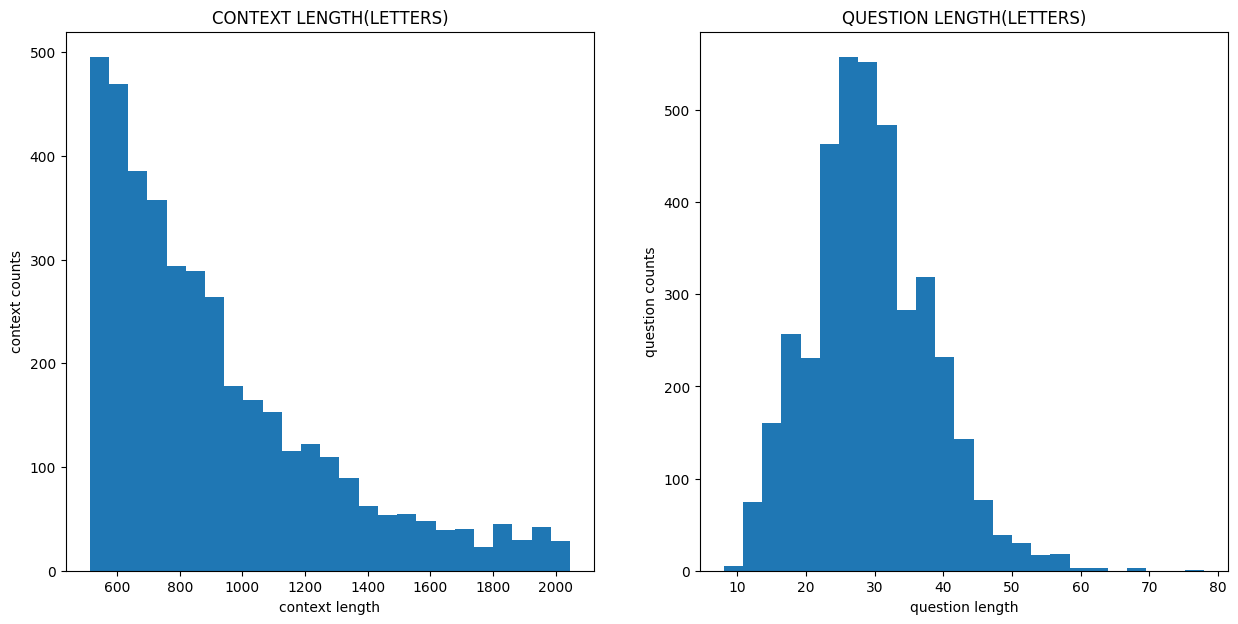

In [28]:
plt.figure(figsize = (15,7))

plt.subplot(1,2,1)

plt.hist(df['context_len'], bins = 25)
plt.xlabel('context length')
plt.ylabel('context counts')
plt.title('CONTEXT LENGTH(LETTERS)')

plt.subplot(1,2,2)
plt.hist(df['question_len'], bins = 25)
plt.xlabel('question length')
plt.ylabel('question counts')
plt.title('QUESTION LENGTH(LETTERS)')

plt.show()

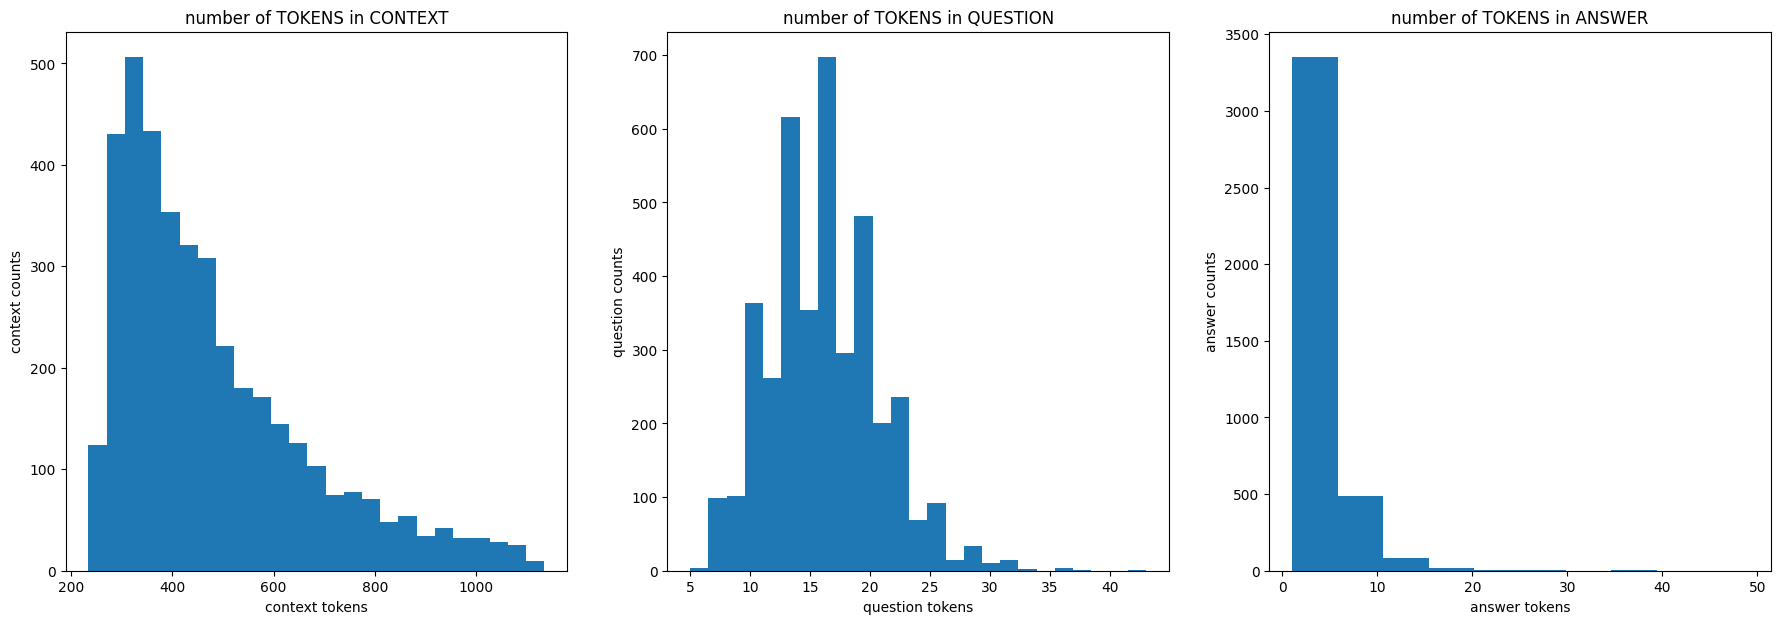

In [29]:
plt.figure(figsize = (22,7))

plt.subplot(1,3,1)

plt.hist(df['context_tokens'], bins = 25)
plt.xlabel('context tokens')
plt.ylabel('context counts')
plt.title('number of TOKENS in CONTEXT')

plt.subplot(1,3,2)
plt.hist(df['question_tokens'], bins = 25)
plt.xlabel('question tokens')
plt.ylabel('question counts')
plt.title('number of TOKENS in QUESTION')

plt.subplot(1,3,3)
plt.hist(df['answer_tokens'], bins = 10)
plt.xlabel('answer tokens')
plt.ylabel('answer counts')
plt.title('number of TOKENS in ANSWER')


plt.show()

## answer 분석
우선 answer에 [UNK] 가 있으면 맞출 수 없는 answer라고 생각해 몇개인지 봤습니다.  
68개로 1.72%입니다. 생각보다 많네여...

In [33]:
answers = df['text'].tolist()
#print(answers)
bert_unk_in_answers = 0
for answer in answers:
    ans = bert_tokenizer.tokenize(answer)
    if '[UNK]' in ans: bert_unk_in_answers += 1
print('answers including [UNK] :', bert_unk_in_answers)
print('percentage:',bert_unk_in_answers*100/len(df),'%')

answers including [UNK] : 68
percentage: 1.7206477732793521 %


그다음엔 answer가 주로 context의 전/중/후 어느 부분쯤에 위치하는지 확인해봤습니다.  
확인 결과 다소 앞부분에 몰려 있는 것 같지만 분포가 고른 편이라 특이점은 없다고 생각했습니다.  

**[그래프 해설]**  
x축 : answer_start index의 위치를 총 context 길이의 %로 나타냄.  
y축 : 해당 구간에 answer_start index가 있는 question의 개수

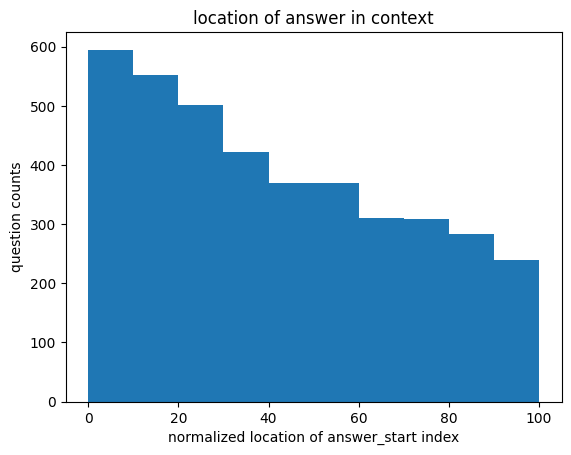

In [176]:
answer_start = df['answer_start'].tolist()
context_len = df['context_len'].tolist()

loca = []
for i in range(len(answer_start)):
    loca.append(int(answer_start[i]*100//context_len[i]))

plt.hist(loca, bins = 10)
plt.xlabel('normalized location of answer_start index')
plt.ylabel('question counts')
plt.title('location of answer in context')
plt.show()

이번엔 형태소분석기를 사용해서 answer의 형태소는 주로 뭔지 분석해보도록 하겠습니다.  
형태소분석기는 `Hannanum`를 사용했습니다.  
첨언하자면 분석기를 뭘 쓸지도 고민을 좀 했는데, 답안이 명사에 몰릴 것 같아서 우선 큰 카테고리로 나눠서 일차로 보고-> 세분화 를 하는데 가장 적합하다고 생각했습니다.  
Hannanum는 `ntags` 변수를 사용해서 세분화 정도를 지정할 수 있거든요.  
형태소분석기 비교표는 [링크](https://docs.google.com/spreadsheets/d/1OGAjUvalBuX-oZvZ_-9tEfYD2gQe7hTGsgUpiiBSXI8/edit#gid=0) 를 참고해주세요.

In [178]:
!apt install default-jdk
!pip install konlpy

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
     |████████████████████████████████| 19.4 MB 20.8 MB/s eta 0:00:01
     |████████████████████████████████| 465 kB 90.0 MB/s eta 0:00:01
     |████████████████████████████████| 7.1 MB 75.6 MB/s eta 0:00:01


`konlpy` 콜 할때   
`unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), is another process using it?`
혹시 이 에러가 발생하면

`- sudo rm /var/lib/apt/lists/lock`  
`- sudo rm /var/cache/apt/archives/lock`  
`- sudo rm /var/lib/dpkg/lock*  `  

을 치세요

우선 일차로 `ntags`=9로 형태소 분리 해 보겠습니다.

{'N': 6394, 'P': 332, 'M': 81, 'I': 25, 'J': 1051, 'E': 661, 'X': 129, 'S': 360, 'F': 125}


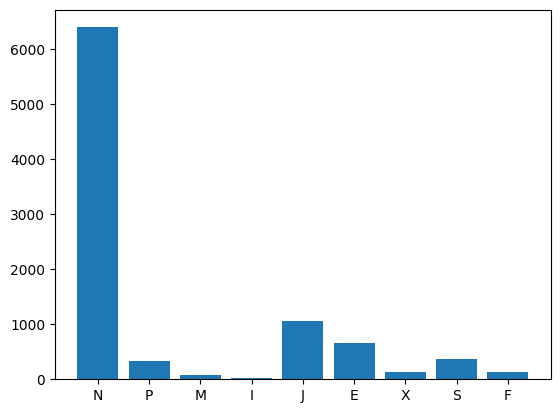

In [218]:
from konlpy.tag import Hannanum
hnn = Hannanum()
hnn_cnt_1 = {'N':0, 'P':0, 'M':0, 'I':0, 'J':0, 'E':0, 'X':0, 'S':0, 'F':0}
#순서대로 N:체언 P:용언 M:수식언 I:독립언 J:관계언 E:어미 X:접사 S:기호 F:외국어
for answer in answers:
    postagged = hnn.pos(answer, ntags=9)
    for pos in postagged:
        hnn_cnt_1[pos[1]] += 1

print(hnn_cnt_1)


plt.bar(*zip(*hnn_cnt_1.items()))
plt.title('component distribution of answers')
plt.show()

역시 명사가 압도적으로 많네요. 그럼 이번엔 명사'만' 추출해서 돌려보고 분포를 확인해보겠습니다.

{'NC': 5400, 'NQ': 0, 'NB': 853, 'NN': 781, 'NP': 20}


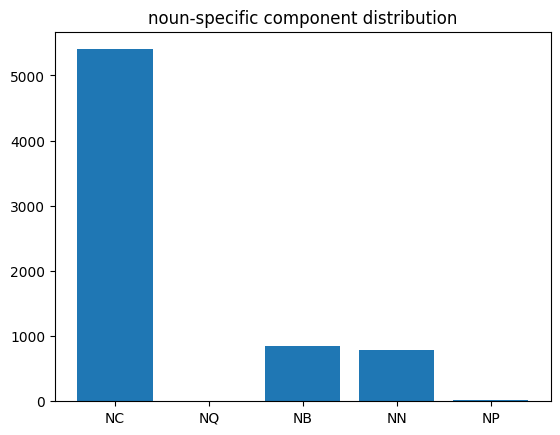

In [236]:
hnn_cnt_nouns = {'NC':0, 'NQ':0, 'NB':0, 'NN':0, 'NP':0}
noun_list = ['NC','NQ','NB','NN', 'NP']
#NC :보통명사 NQ: 고유명사 NB: 의존명사 NN:수사 NP:대명사

for answer in answers:
    postagged = hnn.pos(answer, ntags=22)
    for pos in postagged:
        if pos[1] in noun_list:
            hnn_cnt_nouns[pos[1]] += 1

print(hnn_cnt_nouns)


plt.bar(*zip(*hnn_cnt_nouns.items()))
plt.title('noun-specific component distribution')
plt.show()

명사 중에서도 일반명사가 절대다수의 비율이네요. 뭔가 classification 에 쓸 수 있을 듯 하기도 없을 듯 하기도 합니다.  
NN은 확실히 question classification 이 가능하긴 하겠지만, 이건 아마 쉬운 문제로 분류될 것 같긴 해서요 

그럼 이제 주어진 wiki corpus를 불러오고 예시를 몇 개 보며 분석해 보겠습니다
## Wiki corpus

In [249]:
import json
from pandas import json_normalize

file_path = 'wikipedia_documents.json'

with open(file_path, 'r') as json_file:
    json_data =json.load(json_file)

In [248]:
print(json_data['0'])
print(tokenizer.tokenize(json_data['0']['text']))
print(json_data['3'])
print(tokenizer.tokenize(json_data['3']['text']))
print(json_data['7805'])
print(tokenizer.tokenize(json_data['7805']['text']))

{'text': '이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개요 형태로 나열하고 있다.\n\n이 목록은 명료화를 위해 두 부분으로 나뉘어 있다.\n\n# 첫 번째 부분은 바티칸 시국과 팔레스타인을 포함하여 유엔 등 국제 기구에 가입되어 국제적인 승인을 널리 받았다고 여기는 195개 나라를 나열하고 있다.\n# 두 번째 부분은 일부 지역의 주권을 사실상 (데 팍토) 행사하고 있지만, 아직 국제적인 승인을 널리 받지 않았다고 여기는 11개 나라를 나열하고 있다.\n\n두 목록은 모두 가나다 순이다.\n\n일부 국가의 경우 국가로서의 자격에 논쟁의 여부가 있으며, 이 때문에 이러한 목록을 엮는 것은 매우 어렵고 논란이 생길 수 있는 과정이다. 이 목록을 구성하고 있는 국가를 선정하는 기준에 대한 정보는 "포함 기준" 단락을 통해 설명하였다. 나라에 대한 일반적인 정보는 "국가" 문서에서 설명하고 있다.', 'corpus_source': '위키피디아', 'url': 'TODO', 'domain': None, 'title': '나라 목록', 'author': None, 'html': None, 'document_id': 0}
['이', '문서', '##는', '나라', '목록', '##이', '##며', ',', '전', '세계', '206', '##개', '나라', '##의', '각', '현황', '##과', '주권', '승인', '정보', '##를', '개요', '형태', '##로', '나열', '##하고', '있', '##다', '.', '이', '목록', '##은', '명료', '##화', '##를', '위해', '두', '부분', '##으로', '나뉘', '##어', '있', '##다', '.', '#', '첫', '번', '##째', '부분', '##은', '바티칸', '시국', '##과', '팔레스타인', '##을', '포함', '##하여', '유엔', '등', '국제', '기구', '##에', '가입', '##되',

몇 개만 봤는데 벌써 어지럽다. 위키 데이터 전처리 관련은 별도 노트북에 분리했으므로 여기서는 간단하게 경향만 보고 넘어가겠습니다

In [35]:
df_wiki=pd.read_json("wikipedia_documents.json").transpose()
df_wiki["text_length"]=df_wiki['text'].apply(lambda x:len(x))
df_wiki['text_tokens'] = df_wiki['text'].apply(token_cnt)
df_wiki['text_unks'] = df_wiki['text'].apply(unk_token_cnt)

df_wiki

,text,corpus_source,url,domain,title,author,html,document_id,text_length,text_tokens,text_unks
0,"이 문서는 나라 목록이며, 전 세계 206개 나라의 각 현황과 주권 승인 정보를 개...",위키피디아,TODO,None,나라 목록,None,None,0,454,223,0
1,이 목록에 실린 국가 기준은 1933년 몬테비데오 협약 1장을 참고로 하였다. 협정...,위키피디아,TODO,None,나라 목록,None,None,1,2276,1131,0
2,현 서울특별시 종로구 서린동 (구 일제 강점기 경기도 경성부 서린정) 출신이다. 친...,위키피디아,TODO,None,백남준,None,None,2,5068,2482,6
3,"아오조라 문고(靑空文庫, あおぞらぶんこ|아오조라 분고)는 ‘일본어판 구텐베르크 프로...",위키피디아,TODO,None,아오조라 문고,None,None,3,601,303,2
4,저자 사망 이후 50년이 지나 저작권이 소멸한 메이지 시대부터 쇼와 시대 초기까지의...,위키피디아,TODO,None,아오조라 문고,None,None,4,465,257,0
...,...,...,...,...,...,...,...,...,...,...,...
60608,"오키나와 현립 박물관·미술관( , Okinawa Prefectural Museum ...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60608,612,302,1
60609,"1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)...",위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60609,839,445,37
60610,박물관은 개관 10주년이되는 2017년에 관의 애칭 및 마스코트를 일반인에게 공모했...,위키피디아,None,None,오키나와 현립 박물관·미술관,None,None,60610,307,158,0
60611,단결권 및 단체교섭권 협약(Right to Organise and Collectiv...,위키피디아,None,None,단결권 및 단체교섭권 협약,None,None,60611,302,135,0


In [36]:
df_wiki.describe()

,text_length,text_tokens,text_unks
count,60613.000000,60613.000000,60613.000000
mean,755.565044,404.209955,6.199116
std,762.962671,430.679118,57.864140
min,184.000000,54.000000,0.000000
25%,414.000000,220.000000,0.000000
50%,577.000000,307.000000,0.000000
75%,857.000000,457.000000,4.000000
max,46099.000000,27539.000000,6316.000000


예시로 한 개의 passage가 어떻게 tokenizing 되는지 확인하겠습니다

In [39]:
print(df_wiki['text'][60609])
print(bert_tokenizer.tokenize((df_wiki['text'][60609])))

1936년 7월, 오키나와현 교육위원회 부설 향토 박물관(沖縄県教育会附設郷土博物館)이 슈리성 내 북쪽 부분을 사용하여 개관되었다. 하지만 이 본관은 1945년 오키나와 전투에서 피해를 입어 전소하였다. 같은 해 8월, 류큐 열도 미국군정부의 윌러드 A. 해나 소령이 남아 있는 문화재를 수집하여 이시카와시 (현재 우루마시)에서 오키나와 진열관(沖縄陳列館)을 개설하여 공개했다.

1946년 3월 슈리에서 슈리성 주변의 폐허에서 잔존 문화재의 수집 활동이 이루어 지고, 슈리 시립 향토 박물관(首里市立郷土博物館)이 설립된다.

1946년 4월에 오키나와 진열관이 오키나와 민정부에 이관되어 오키나와 민정부립 히가시온나 박물관(沖縄民政府立東恩納博物館)으로 개명한다.

1947년 12월 슈리 시립 향토 박물관이 오키나와 민정부에 이관되어 오키나와 민정부립 슈리 박물관(沖縄民政府立首里博物館)으로 개명한다.

1953년 3월, 슈리 박물관이 오키나와 민정부립 히가시온나 박물관을 흡수 합병한다. 같은 해 9월, 류큐 정부립 박물관(琉球政府立博物館)으로 개명한다.

1966년 10월 6일, 슈리다이나카초의 나카구스쿠 저택 터에 신관이 준공 (이전 현립 박물관 구관)되었다.

1972년 5월 15일 오키나와 반환 후 본토로 복귀하여 류큐 정부 하에 오키나와 현립 박물관으로 바뀌며 2층 증축 공사를 시작한다. 1973년 11월, 2층 증축 공사가 완료되었다. 2006년 3월, 오모로마치의 신관으로 이전하기 위해 휴관한다. 2006년 11월, 오키나와 현립 박물관·미술관의 박물관 시설 준공되었다. 2007년 3월, 오키나와 현립 박물관·미술관으로 이전이 완료되어 전신인 오키나와 현립 박물관은 폐관한다.
['1936', '##년', '7', '##월', ',', '오키나와', '##현', '교육', '##위원회', '부설', '향토', '박물관', '(', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '[UNK]', '

다음은 passage의 글자/토큰 길이 분포, passage별 [UNK] 의 개수와 비율 분포를 그래프로 확인했습니다

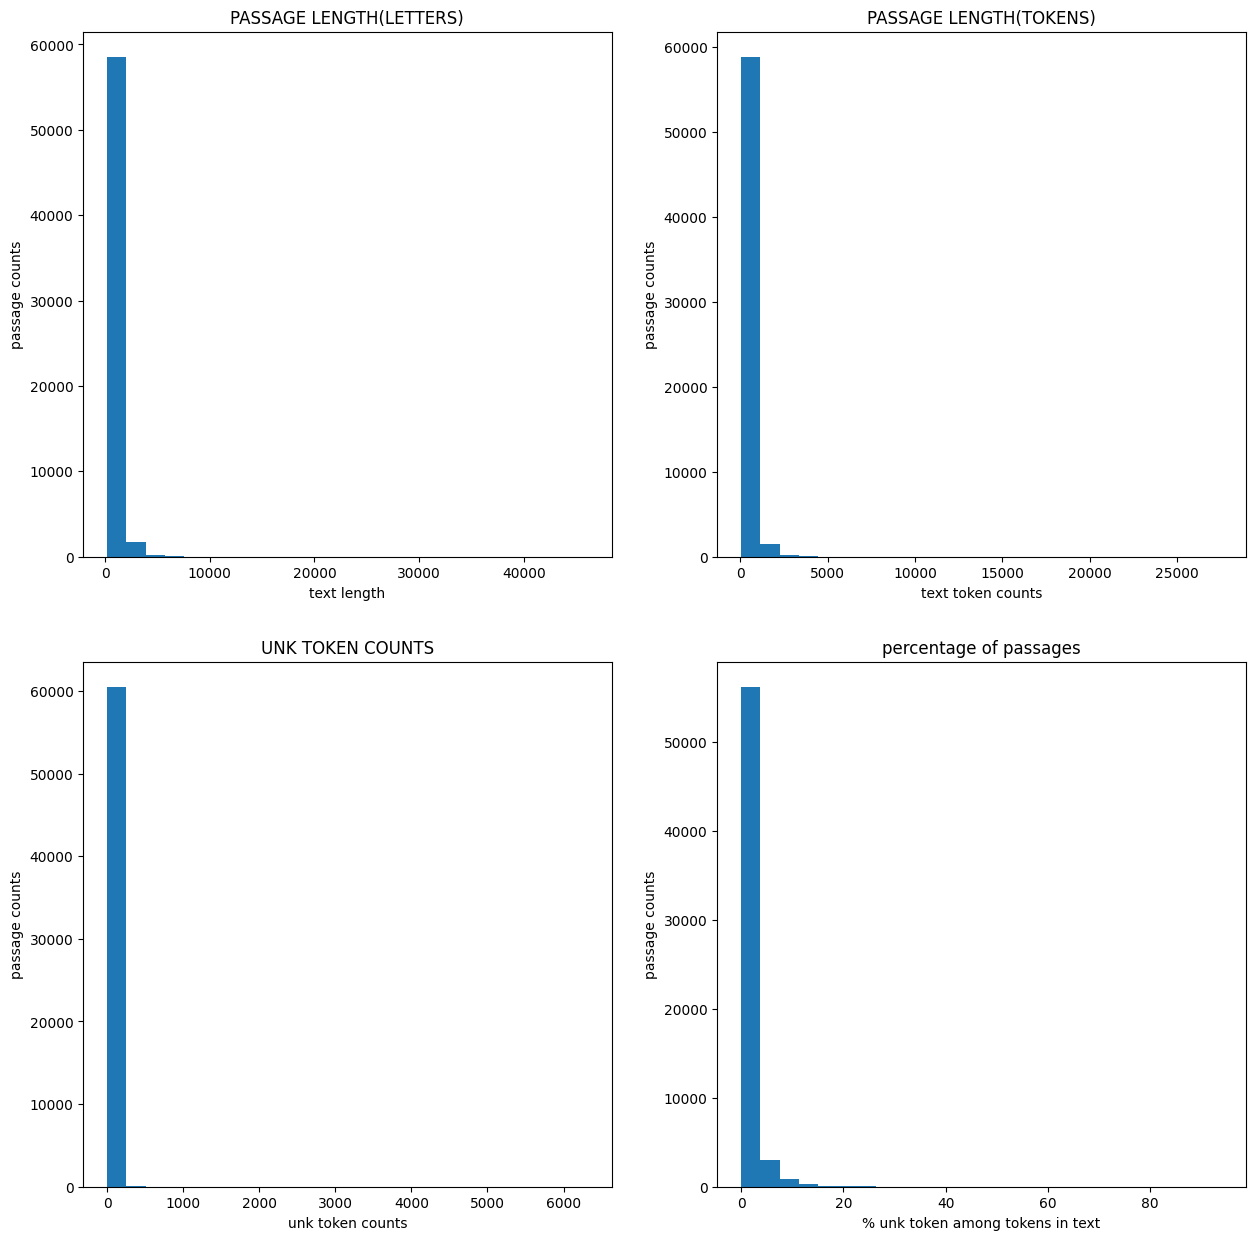

In [40]:
text_tokens = df_wiki['text_tokens'].tolist()
unk_tokens = df_wiki['text_unks'].tolist()

normalized_unk_cnt = []
for i in range(len(text_tokens)):
    normalized_unk_cnt.append(int(unk_tokens[i]*100//text_tokens[i]))


plt.show()

plt.figure(figsize = (15,15))

plt.subplot(2,2,1)

plt.hist(df_wiki['text_length'], bins=25)
plt.xlabel('text length')
plt.ylabel('passage counts')
plt.title('PASSAGE LENGTH(LETTERS)')

plt.subplot(2,2,2)
plt.hist(df_wiki['text_tokens'], bins = 25)
plt.xlabel('text token counts')
plt.ylabel('passage counts')
plt.title('PASSAGE LENGTH(TOKENS)')

plt.subplot(2,2,3)
plt.hist(df_wiki['text_unks'], bins = 25)
plt.xlabel('unk token counts')
plt.ylabel('passage counts')
plt.title('UNK TOKEN COUNTS')

plt.subplot(2,2,4)
plt.hist(normalized_unk_cnt, bins = 25)
plt.xlabel('% unk token among tokens in text')
plt.ylabel('passage counts')
plt.title('percentage of passages')
plt.show()

세 가지 플랏(passage length(letter/token), unk token count) 다 무지 꼬리가 길므로 outlier로 생각해서 과감히 없애도 될 것 같다고 생각했습니다.  
wiki data를 어떻게 전처리를 잘 해야 [UNK]를 최소화할지 고민됩니다. 
그러나 대부분의 데이터(5500개 이상 -> 92%) 이 전체 passage 토큰 중 [UNK] 토큰이 차지하는 비율이 4% 아래라 무시해도 되려나? 싶기도 합니다.

dataset, wikipedia-documents의 [UNK] 토큰에 대한 보다 자세한 분석은 `analysis_dataset_unks.ipynb` 에서 확인할 수 있습니다.  
이상으로 EDA를 마칩니다